In [15]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import time
import os
import cv2

from torchvision import tv_tensors
from skimage import io, transform
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

plt.rcParams["figure.figsize"] = (10, 5)

In [16]:
DATASET_PATH = "./data/dataset"
TRAIN_LABELS = "./data/train_labels.csv"
TEST_LABELS = "./data/test_labels.csv"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCHS = 3
RESIZE_TO = 512
BATCH_SIZE = 2

CLASSES = [
    '__background__', '0'
]
NUM_CLASSES = len(CLASSES)

In [17]:
DEVICE

'cpu'

In [18]:
labels_map = {
    '0': "Stenosis",
}

In [19]:
def cut_frame(image):
    """Cuts black frame of the image."""
    # treshold implementation
    [H,W,n] = image.shape
    ret, thresh = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY_INV)
    edged = cv2.Canny(thresh, 0,50)
    contours,_ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
    [x,y,w,h] = sorted(boundRect, key=lambda coef: coef[3])[-1]
    
    # check output points, if points are incorrect set default values
    default_val=60 # to adjust
    if x>100 or y>100: # to adjust
        x=y=default_val
        w=h=H-default_val
    if w<300 or h<300: # to adjust
        x=y=default_val
        w=h=H-default_val      
    return x,y,w,h

In [20]:
def img_transform(img, bbox, img_target_size=512):
    """Runs sequence of image preprocessing steps."""
    bbox_x, bbox_y, bbox_dx, bbox_dy = bbox[0]
    
    # crop borders
    nx, ny, ndx, ndy = cut_frame(img)
    img_cropped = img[nx:ndx, ny:ndy]
    
    # calculate new coordinates of bbox
    bbox_nx, bbox_ny = bbox_x - nx, bbox_y - ny
    bbox_ndx, bbox_ndy = bbox_dx - nx, bbox_dy - ny
    
    img_height, img_width, _ = img_cropped.shape
    img_height_scale, img_width_scale = img_target_size/img_height, img_target_size/img_width
    
    # resize image
    img_resized = cv2.resize(
        img_cropped, (img_target_size, img_target_size)
    )

    # resize bbox
    bbox_nx_resized = int(np.round(bbox_nx * img_width_scale))
    bbox_ny_resized = int(np.round(bbox_ny * img_height_scale))
    bbox_ndx_resized = int(np.round(bbox_ndx * img_width_scale))
    bbox_ndy_resized = int(np.round(bbox_ndy * img_height_scale))
    bbox_resized = [[bbox_nx_resized, bbox_ny_resized, bbox_ndx_resized, bbox_ndy_resized]]
    
    return img_resized, bbox_resized

In [21]:
# LATER ADD AUGMENTATION AND RANDOM CROP

In [22]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = T.ToTensor()(image)
        return image

In [23]:
class CoronarographyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, N=30):
        self.img_labels = pd.read_csv(annotations_file).head(N)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx: int):
            
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = io.imread(img_path)
        # img_size = self.img_labels.iloc[idx, 1:3].values.astype(int)
        bbox = self.img_labels.iloc[idx, 4:].values.astype(int)
        bbox = np.array([bbox], dtype=int)
        # there is only one class
        labels = torch.ones((1), dtype=torch.long)
        image, bbox = img_transform(image, bbox)
        
        if self.transform:
            image = self.transform(image)

        bbox = torch.FloatTensor(bbox)
        target = {"boxes": bbox, "label": labels}
        
        return image, target

In [24]:
dset = CoronarographyDataset(annotations_file=TRAIN_LABELS, img_dir=DATASET_PATH, transform=None)

In [25]:
dset[1]

(array([[[151, 151, 151],
         [151, 151, 151],
         [152, 152, 152],
         ...,
         [177, 177, 177],
         [172, 172, 172],
         [173, 173, 173]],
 
        [[153, 153, 153],
         [154, 154, 154],
         [151, 151, 151],
         ...,
         [177, 177, 177],
         [175, 175, 175],
         [175, 175, 175]],
 
        [[152, 152, 152],
         [157, 157, 157],
         [145, 145, 145],
         ...,
         [176, 176, 176],
         [174, 174, 174],
         [175, 175, 175]],
 
        ...,
 
        [[125, 125, 125],
         [128, 128, 128],
         [127, 127, 127],
         ...,
         [140, 140, 140],
         [143, 143, 143],
         [148, 148, 148]],
 
        [[120, 120, 120],
         [121, 121, 121],
         [126, 126, 126],
         ...,
         [142, 142, 142],
         [142, 142, 142],
         [144, 144, 144]],
 
        [[129, 129, 129],
         [122, 122, 122],
         [124, 124, 124],
         ...,
         [139, 139, 139],
  

In [26]:
def show_bbox(image, bbox):
    plt.imshow(image)
    bbox_x, bbox_y, bbox_dx, bbox_dy = bbox[0]
    rect = patches.Rectangle(
        (bbox_x, bbox_y), bbox_dx - bbox_x, bbox_dy - bbox_y, linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    plt.pause(0.001)

0 (512, 512, 3) tensor([[132.,  72., 167.,  99.]])


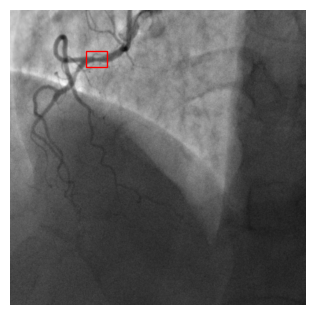

1 (512, 512, 3) tensor([[270., 195., 291., 218.]])


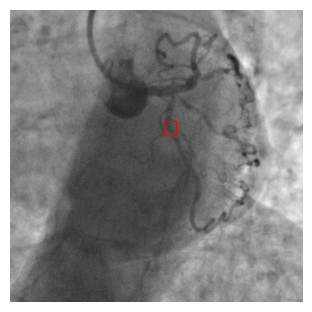

2 (512, 512, 3) tensor([[360., 144., 372., 161.]])


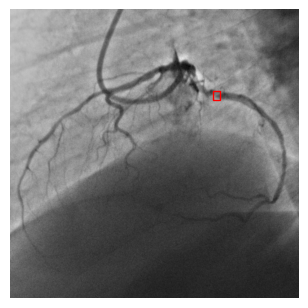

In [27]:
dset = CoronarographyDataset(annotations_file=TRAIN_LABELS, img_dir=DATASET_PATH, transform=None)

img_n = 3
fig = plt.figure()
for i, (image, target) in enumerate(dset):
    bbox = target["boxes"]
    print(i, image.shape, bbox)
    
    ax = plt.subplot(1, img_n, i + 1)
    plt.tight_layout()
    ax.axis('off')
    show_bbox(image, bbox)
    
    if i == img_n-1: 
        plt.show()
        break

In [32]:
train_ds = torch.utils.data.DataLoader(
    CoronarographyDataset(
        annotations_file=TRAIN_LABELS, img_dir=DATASET_PATH, transform=T.Compose([ToTensor()]), N=30), 
        batch_size=BATCH_SIZE, shuffle=True, #num_workers=4
)
test_ds = torch.utils.data.DataLoader(
    CoronarographyDataset(
        annotations_file=TEST_LABELS, img_dir=DATASET_PATH, transform=T.Compose([ToTensor()]), N=30), 
    batch_size=BATCH_SIZE, shuffle=False, #num_workers=1
)

In [33]:
for t in train_ds:
    print(t)
    break

[tensor([[[[0.3765, 0.3333, 0.3098,  ..., 0.7490, 0.7529, 0.7608],
          [0.3294, 0.3216, 0.3059,  ..., 0.7451, 0.7529, 0.7608],
          [0.3529, 0.3137, 0.2902,  ..., 0.7451, 0.7569, 0.7608],
          ...,
          [0.6235, 0.6392, 0.6471,  ..., 0.5255, 0.5294, 0.5333],
          [0.6431, 0.6431, 0.6196,  ..., 0.5255, 0.5451, 0.5451],
          [0.6510, 0.6118, 0.6275,  ..., 0.5412, 0.5451, 0.5451]],

         [[0.3765, 0.3333, 0.3098,  ..., 0.7490, 0.7529, 0.7608],
          [0.3294, 0.3216, 0.3059,  ..., 0.7451, 0.7529, 0.7608],
          [0.3529, 0.3137, 0.2902,  ..., 0.7451, 0.7569, 0.7608],
          ...,
          [0.6235, 0.6392, 0.6471,  ..., 0.5255, 0.5294, 0.5333],
          [0.6431, 0.6431, 0.6196,  ..., 0.5255, 0.5451, 0.5451],
          [0.6510, 0.6118, 0.6275,  ..., 0.5412, 0.5451, 0.5451]],

         [[0.3765, 0.3333, 0.3098,  ..., 0.7490, 0.7529, 0.7608],
          [0.3294, 0.3216, 0.3059,  ..., 0.7451, 0.7529, 0.7608],
          [0.3529, 0.3137, 0.2902,  ..., 

In [38]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = NUM_CLASSES  # 1 class (stenosis) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(DEVICE)

In [39]:
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(test_ds)}\n")

Number of training samples: 15
Number of validation samples: 15



In [40]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/best_model.pth')

def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/last_model.pth')

In [89]:
def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [44]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model_faster_rcnn'

save_best_model = SaveBestModel()

for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    start = time.time()
    
    prog_bar = tqdm(train_ds, total=len(train_ds))
    
    # training
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, bboxes = data
        targets = []
        for i in range(len(images)):
            d = {}
            d['boxes'] = bboxes['boxes'][0]
            d['labels'] = bboxes['label'][0]
            targets.append(d)
            
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value) #
        
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    prog_bar = tqdm(test_ds, total=len(test_ds))

    for i, data in enumerate(prog_bar):
        images, targets = data
        targets = []
        for i in range(len(images)):
            d = {}
            d['boxes'] = bboxes['boxes'][0]
            d['labels'] = bboxes['label'][0]
            targets.append(d)

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value) #
        
        val_loss_hist.send(loss_value)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    
    # save the best model till now if we have the least loss in the...
    # ... current epoch
    save_best_model(
        val_loss_hist.value, epoch, model, optimizer
    )
    # save the current epoch model
    save_model(epoch, model, optimizer)
    
    # # save loss plot
    # save_loss_plot(OUT_DIR, train_loss, val_loss)
    
    # sleep for 5 seconds after each epoch
    time.sleep(5)


EPOCH 1 of 3


Loss: 0.1832: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


Epoch #1 train loss: 0.168
Epoch #1 validation loss: 0.152
Took 1.581 minutes for epoch 0

Best validation loss: 0.1521570235490799

Saving best model for epoch: 1


EPOCH 2 of 3


Loss: 0.0946: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Epoch #2 train loss: 0.158
Epoch #2 validation loss: 0.087
Took 1.554 minutes for epoch 1

Best validation loss: 0.08734896704554558

Saving best model for epoch: 2


EPOCH 3 of 3


Loss: 0.0710: 100%|██████████| 15/15 [00:26<00:00,  1.73s/it]


Epoch #3 train loss: 0.172
Epoch #3 validation loss: 0.087
Took 1.561 minutes for epoch 2

Best validation loss: 0.08692502081394196

Saving best model for epoch: 3



<Axes: >

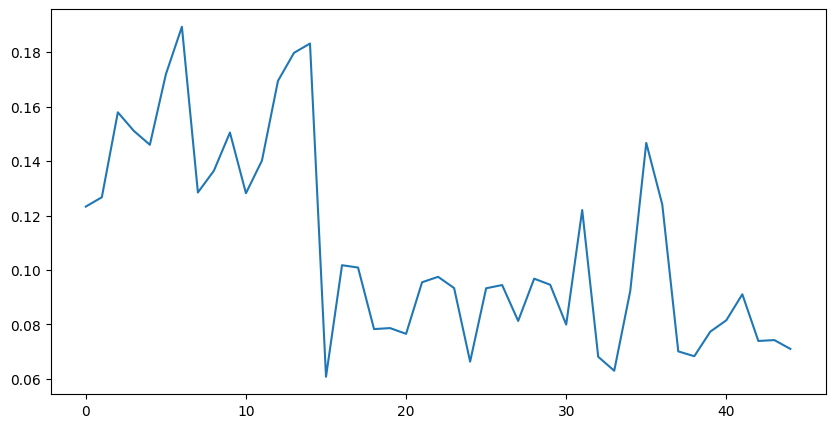

In [47]:
pd.Series(val_loss_list).plot()

<Axes: >

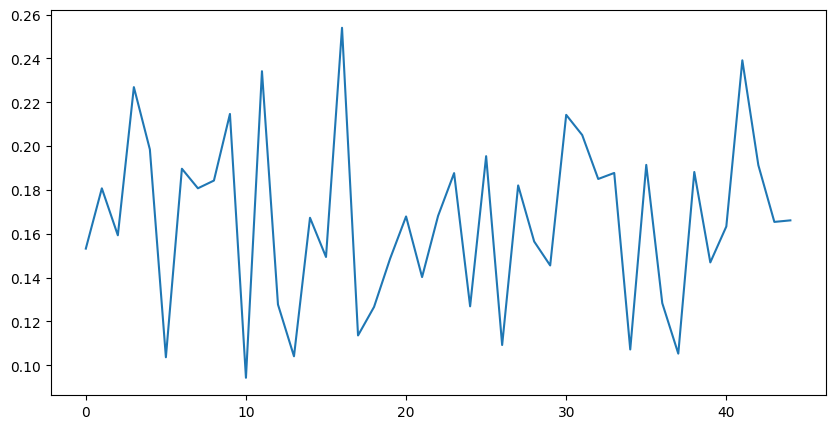

In [48]:
pd.Series(train_loss_list).plot()

In [90]:
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

/Users/magdalenamarecik/anaconda3/envs/yolov8_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/magdalenamarecik/anaconda3/envs/yolov8_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [75]:
detection_threshold = 0.01

In [76]:
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0 

In [79]:
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [77]:
test_images = ['14_066_8_0028.bmp', '14_048_1_0057.bmp', '14_051_2_0051.bmp', '14_051_2_0025.bmp', '14_021_16_0077.bmp']
test_images = [os.path.join(DATASET_PATH, img) for img in test_images]

In [91]:
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float)#.cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    end_time = time.time()
    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        print(outputs)
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 2)
            cv2.putText(orig_image, class_name, 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                        2, lineType=cv2.LINE_AA)
        cv2.imshow('Prediction', orig_image)
        cv2.waitKey(1)
        cv2.imwrite(f"inference_outputs/images/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

[{'boxes': tensor([[208.0462, 152.6005, 229.0367, 191.8793],
        [180.7250, 143.6035, 240.9477, 203.7502],
        [197.3966, 148.7700, 235.3617, 187.6880]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.0590, 0.0567, 0.0559])}]
Image 1 done...
--------------------------------------------------
Image 2 done...
--------------------------------------------------
Image 3 done...
--------------------------------------------------
[{'boxes': tensor([[170.2701, 109.6828, 208.8962, 146.7991],
        [195.7508, 113.0826, 205.0276, 132.9040]]), 'labels': tensor([1, 1]), 'scores': tensor([0.0534, 0.0526])}]
Image 4 done...
--------------------------------------------------
Image 5 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE
Average FPS: 1.713


In [388]:
# print(model)

In [399]:
torch.__version__

'2.3.0.dev20240302'

In [ ]:
# model.to(mps_device)
# for epochs in tqdm(range(num_epochs)):
#     epoch_loss = 0
#     for (images, labels_boxes) in tqdm(train_ds):
#         imgs = []
#         targets = []
#         for i in range(len(images)):
#             imgs.append(images[i].to(mps_device))
#             d = {}
#             d['boxes'] = labels_boxes['boxes'][0].to(mps_device)
#             d['labels'] = labels_boxes['label'][0].to(mps_device)
#             targets.append(d)
#         loss_dict = model(imgs, targets)
#         loss = sum(v for v in loss_dict.values())
#         epoch_loss += loss.cpu().detach().numpy()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(epoch_loss)
        
#         # (images, labels, bboxes) = images.to(mps_device), labels_boxes['label'].to(mps_device), labels_boxes['boxes'].to(mps_device)
#         # target = {
#         #     "boxes": bboxes,
#         #     "labels": labels,
#         # }

  0%|          | 1/3747 [02:27<153:48:14, 147.81s/it]

In [48]:
# tv_tensors.BoundingBoxes(x, format="XYXY", canvas_size=size)

BoundingBoxes([[235, 156, 282, 192]], format=BoundingBoxFormat.XYXY, canvas_size=[800 800])